<a href="https://colab.research.google.com/github/JoonYoung-Sohn/practice/blob/master/FastAI_Conv_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.basics import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [4]:
il = ImageList.from_folder(path, convert_mode='L')

In [5]:
print(il.items[0])
print(len(il.items))
defaults.cmap='binary'
print(il)

/root/.fastai/data/mnist_png/training/8/37398.png
70000
ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png


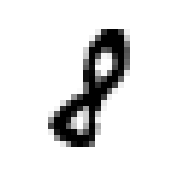

In [6]:
il[0].show()

In [7]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [8]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/2')]

In [9]:
ll = sd.label_from_folder()
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Test: None

8 torch.Size([1, 28, 28])


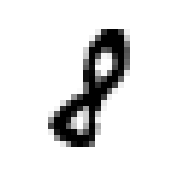

In [10]:
x,y = ll.train[0]
x.show()
print(y,x.shape)

8


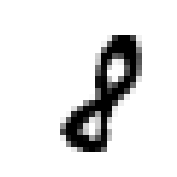

In [11]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
ll = ll.transform(tfms)
bs = 128
data = ll.databunch(bs=bs).normalize()
x,y = data.train_ds[0]
x.show()
print(y)

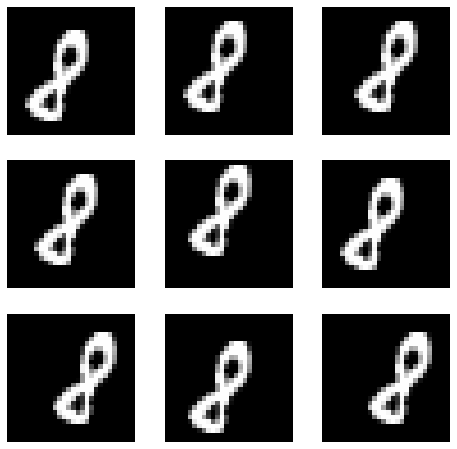

In [12]:
def _plot(i,j,ax):
  data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [13]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

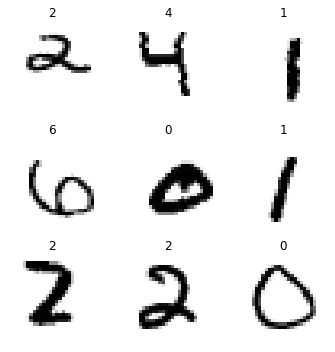

In [14]:
data.show_batch(rows=3, figsize=(5,5))

In [15]:
def conv(ni,nf):
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [16]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [17]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [18]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [19]:
xb = xb.cuda() #GPU only

In [20]:
model(xb).shape

torch.Size([128, 10])

In [21]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


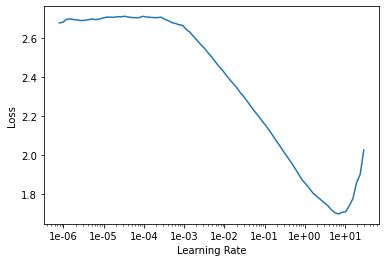

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229317,0.182283,0.939900,00:29
1,0.133698,0.108985,0.966800,00:29
2,0.070214,0.041845,0.988000,00:29


- - -

In [24]:
def conv2(ni,nf):
  return conv_layer(ni,nf,stride=2)

In [25]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [26]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [27]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.238581,0.145608,0.953600,00:28
1,0.183550,0.122322,0.962200,00:27
2,0.167159,0.182889,0.941200,00:27
3,0.148211,0.107938,0.966200,00:27
4,0.114145,0.084913,0.973100,00:27
5,0.110642,0.101333,0.968400,00:28
6,0.083624,0.048123,0.984900,00:27
7,0.060223,0.036852,0.988600,00:27
8,0.049971,0.031846,0.989400,00:28
9,0.048291,0.027917,0.991100,00:28
